### 01. 라이브러리 임포트

In [2]:
!pip install catboost

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
import sklearn.metrics as mt

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score

### 02. 데이터 불러오기 (xlsx)

In [4]:
df = pd.read_excel('wpdb.xlsx')
df.head()

,UID,CenterId,StudentName,SchoolName,SchoolGrade,SchoolLevel,StudentGrade,Address,Address2,StudentStatus,cs_count,max_sche_date,withdraw_csl_count,remain_csl_count,supply_count,clinic_count,abs_count,pre_count,target
0,00249736-53A0-4D68-8CB9-DFA306A33435,15,임현승,성동중학교,1학년,high,17,NaN,NaN,drop,5,2023-11-17,0,3,0,0,1,41,0
1,00515C99-00A6-444B-93A3-73D7BB0852E5,15,노해율,내성중학교,3학년,middle,16,부산 동래구 금정마을로 135-9(동래 래미안 아이파크),2단지-5호차,present,5,2023-07-20,0,19,0,0,0,52,0
2,00600FC7-C7DE-40DE-AD7D-A1D94DD5D212,16,신아인,경일중학교,3학년,middle,16,부산 강서구 명지국제7로 110(더 힐 시그니처),NaN,present,8,2024-02-15,0,0,0,0,0,0,1
3,0063DEBD-095C-4804-A246-7EDD5160419A,14,손태윤,브니엘예술중학교,3학년,middle,16,NaN,NaN,drop,2,2023-10-01,0,0,0,0,0,6,0
4,007378EC-9A44-4A75-8B1A-70D13FBE7832,16,오주안,오션중학교,3학년,middle,16,NaN,명지 오션 11로 87,present,29,2024-02-15,0,23,0,0,1,278,1


### 03. 학습에 사용될 데이터와 예측 데이터 설정
- 학습 데이터 X
- 예측 데이터 y
    - 0과 1의 값만 존재하며, 분류를 이용하여 예측 예정

In [5]:
X=df[df.columns[6:]]
X.head()

,StudentGrade,Address,Address2,StudentStatus,cs_count,max_sche_date,withdraw_csl_count,remain_csl_count,supply_count,clinic_count,abs_count,pre_count,target
0,17,NaN,NaN,drop,5,2023-11-17,0,3,0,0,1,41,0
1,16,부산 동래구 금정마을로 135-9(동래 래미안 아이파크),2단지-5호차,present,5,2023-07-20,0,19,0,0,0,52,0
2,16,부산 강서구 명지국제7로 110(더 힐 시그니처),NaN,present,8,2024-02-15,0,0,0,0,0,0,1
3,16,NaN,NaN,drop,2,2023-10-01,0,0,0,0,0,6,0
4,16,NaN,명지 오션 11로 87,present,29,2024-02-15,0,23,0,0,1,278,1


In [6]:
X = X.drop(columns = ['Address','Address2', 'max_sche_date', 'StudentStatus'])
X

,StudentGrade,cs_count,withdraw_csl_count,remain_csl_count,supply_count,clinic_count,abs_count,pre_count,target
0,17,5,0,3,0,0,1,41,0
1,16,5,0,19,0,0,0,52,0
2,16,8,0,0,0,0,0,0,1
3,16,2,0,0,0,0,0,6,0
4,16,29,0,23,0,0,1,278,1
...,...,...,...,...,...,...,...,...,...
2492,15,2,1,20,0,0,0,64,1
2493,16,9,0,0,0,0,0,0,1
2494,16,3,1,9,0,0,0,23,0
2495,17,6,0,0,0,0,0,0,1


### 04. 나이 데이터 0, 1, 2로 변환

In [7]:
X['StudentGrade'].replace({15: 0, 16: 1, 17:2}, inplace=True)

In [8]:
X

,StudentGrade,cs_count,withdraw_csl_count,remain_csl_count,supply_count,clinic_count,abs_count,pre_count,target
0,2,5,0,3,0,0,1,41,0
1,1,5,0,19,0,0,0,52,0
2,1,8,0,0,0,0,0,0,1
3,1,2,0,0,0,0,0,6,0
4,1,29,0,23,0,0,1,278,1
...,...,...,...,...,...,...,...,...,...
2492,0,2,1,20,0,0,0,64,1
2493,1,9,0,0,0,0,0,0,1
2494,1,3,1,9,0,0,0,23,0
2495,2,6,0,0,0,0,0,0,1


In [9]:
pd.DataFrame(X).describe()

,StudentGrade,cs_count,withdraw_csl_count,remain_csl_count,supply_count,clinic_count,abs_count,pre_count,target
count,2497.000000,2497.000000,2497.000000,2497.000000,2497.000000,2497.000000,2497.000000,2497.000000,2497.000000
mean,1.080497,10.095715,0.236684,8.060473,0.010813,0.028835,2.785342,64.474169,0.567080
std,0.822076,10.497140,0.648321,9.690521,0.130807,0.447538,5.310735,80.639647,0.495579
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000
50%,1.000000,6.000000,0.000000,4.000000,0.000000,0.000000,0.000000,31.000000,1.000000
75%,2.000000,14.000000,0.000000,13.000000,0.000000,0.000000,3.000000,95.000000,1.000000
max,2.000000,62.000000,19.000000,64.000000,2.000000,11.000000,54.000000,396.000000,1.000000


In [10]:
print(X.shape)
type(X)

(2497, 9)


pandas.core.frame.DataFrame

In [11]:
# 정답(레이블) 설정
y = X['target']
y # 0과 1로 구분, 1:재원 / 0:퇴원

0       0
1       0
2       1
3       0
4       1
       ..
2492    1
2493    1
2494    0
2495    1
2496    0
Name: target, Length: 2497, dtype: int64

In [12]:
print(y.shape)

(2497,)


In [13]:
X = X.drop(columns = ['target'])

In [14]:
X

,StudentGrade,cs_count,withdraw_csl_count,remain_csl_count,supply_count,clinic_count,abs_count,pre_count
0,2,5,0,3,0,0,1,41
1,1,5,0,19,0,0,0,52
2,1,8,0,0,0,0,0,0
3,1,2,0,0,0,0,0,6
4,1,29,0,23,0,0,1,278
...,...,...,...,...,...,...,...,...
2492,0,2,1,20,0,0,0,64
2493,1,9,0,0,0,0,0,0
2494,1,3,1,9,0,0,0,23
2495,2,6,0,0,0,0,0,0


### 05. 결측치 확인

In [15]:
X.isnull().sum()

StudentGrade          0
cs_count              0
withdraw_csl_count    0
remain_csl_count      0
supply_count          0
clinic_count          0
abs_count             0
pre_count             0
dtype: int64

### 06. 데이터 정규화

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler_minmax=MinMaxScaler()
scaler_standard=StandardScaler()

### 1) 학습 데이터의 정규화

In [17]:
'''scaler_minmax.fit(X)
X_scaled_minmax_train=scaler_minmax.transform(X)
pd.DataFrame(X_scaled_minmax_train).describe()'''

# 최소값(min)은 0으로, 최대값(max)은 1로 나타난 걸 확인할 수 있음

'scaler_minmax.fit(X)\nX_scaled_minmax_train=scaler_minmax.transform(X)\npd.DataFrame(X_scaled_minmax_train).describe()'

In [18]:
'''X_scaled_standard_train'''

'X_scaled_standard_train'

### 2) 검증 데이터의 정규화

In [19]:
'''scaler_standard.fit(X_val)
X_scaled_standard_train=scaler_standard.transform(X_val)
pd.DataFrame(X_scaled_standard_train).describe()'''

'scaler_standard.fit(X_val)\nX_scaled_standard_train=scaler_standard.transform(X_val)\npd.DataFrame(X_scaled_standard_train).describe()'

### 3) 테스트 데이터의 정규화

In [20]:
'''X_scaled_minmax_test=scaler_minmax.transform(X_test)
pd.DataFrame(X_scaled_minmax_test).describe()'''

'X_scaled_minmax_test=scaler_minmax.transform(X_test)\npd.DataFrame(X_scaled_minmax_test).describe()'

### 07. 학습 데이터와 검증용 데이터 분리
- Train/Test set 분리
- Train/Validation/Test set 분리

In [33]:
# Train/Test set 분리

from sklearn.model_selection import train_test_split

X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 1) 

# stratify : 훈련 데이터와 테스트 데이터를 구분할 때, 레이블의 범주비율에 맞게 하라는 것 (회귀에는 사용 X)

In [34]:
X_tmp.shape, X_test.shape, y_tmp.shape, y_test.shape

((1997, 8), (500, 8), (1997,), (500,))

In [35]:
# Train/Validation/Test set 분리 (6:2:2)

X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.25, stratify=y_tmp, random_state=0)

In [36]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1497, 8), (500, 8), (500, 8), (1497,), (500,), (500,))

### 08. CatBoostClassifier 생성 및 학습

In [37]:
clf_catboost = CatBoostClassifier(iterations=100, random_state=123)
clf_catboost.fit(X_train, y_train, 
                 cat_features=['StudentGrade'],
                 eval_set=(X_val, y_val))

Learning rate set to 0.095321
0:	learn: 0.6646357	test: 0.6687286	best: 0.6687286 (0)	total: 176ms	remaining: 17.5s
1:	learn: 0.6425576	test: 0.6488769	best: 0.6488769 (1)	total: 186ms	remaining: 9.1s
2:	learn: 0.6222068	test: 0.6321129	best: 0.6321129 (2)	total: 197ms	remaining: 6.38s
3:	learn: 0.6072013	test: 0.6184834	best: 0.6184834 (3)	total: 211ms	remaining: 5.06s
4:	learn: 0.5911994	test: 0.6055759	best: 0.6055759 (4)	total: 221ms	remaining: 4.2s
5:	learn: 0.5752720	test: 0.5913568	best: 0.5913568 (5)	total: 230ms	remaining: 3.6s
6:	learn: 0.5638435	test: 0.5814575	best: 0.5814575 (6)	total: 239ms	remaining: 3.18s
7:	learn: 0.5486641	test: 0.5665674	best: 0.5665674 (7)	total: 249ms	remaining: 2.86s
8:	learn: 0.5338024	test: 0.5517972	best: 0.5517972 (8)	total: 259ms	remaining: 2.62s
9:	learn: 0.5208407	test: 0.5404839	best: 0.5404839 (9)	total: 268ms	remaining: 2.41s
10:	learn: 0.5098546	test: 0.5306788	best: 0.5306788 (10)	total: 278ms	remaining: 2.25s
11:	learn: 0.5036511	test

### 09. 테스트셋에 대한 모델 예측 및 정확도 확인

In [38]:
# 예측
y_pred = clf_catboost.predict(X_test)

In [39]:
# accuracy_score
accuracy_score(y_test, y_pred)

0.856

In [40]:
accuracy = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred,average='macro')
print(f"f1:{f1:4f}   accuracy:{accuracy:.4f}")

f1:0.853446   accuracy:0.8560


In [41]:
confusion_matrix(y_test, y_pred)  

array([[181,  35],
       [ 37, 247]], dtype=int64)

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       216
           1       0.88      0.87      0.87       284

    accuracy                           0.86       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.86      0.86      0.86       500



### 10. 하이퍼 파라미터 튜닝

✅ 최적의 파라미터 조합 구하기

In [43]:
from sklearn.model_selection import GridSearchCV

# Define the CatBoostClassifier
catboost_model = CatBoostClassifier(random_state=123, silent=True)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [4, 6, 8],
    'grow_policy': ['SymmetricTree', 'Lossguide'],  # Include grow_policy for compatibility with max_leaves
    'max_leaves': [5, 10, 20, 50]  # max_leaves is only relevant when grow_policy is Lossguide
}

# Initialize GridSearchCV
grid_search = GridSearchCV(catboost_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train, cat_features=[])

# Output the best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\Ara\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Ara\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Ara\anaconda3\Lib\site-packages\catboost\core.py", line 5220, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\Ara\anaconda3\Lib\site-packages\catboost\core.py", line 2385, in _f

Best parameters found:  {'grow_policy': 'Lossguide', 'learning_rate': 0.01, 'max_depth': 6, 'max_leaves': 20, 'n_estimators': 1000}
Best accuracy:  0.8436811594202899


✅ 최적 파라미터 적용했을 때의 정확도

In [57]:
from lightgbm import LGBMClassifier

# 최적의 하이퍼 파라미터 적용

# 검증 데이터 지정
evals = [(X_test, y_test)]

cat_best = CatBoostClassifier(iterations=1000, random_state=123,
                             grow_policy= 'Lossguide',
                             learning_rate= 0.01,
                             max_depth= 6,
                             max_leaves= 20
                             )


# 학습
cat_best.fit(X_train, y_train,
             cat_features=['StudentGrade'],
             eval_set=evals)

0:	learn: 0.6882684	test: 0.6883810	best: 0.6883810 (0)	total: 36.9ms	remaining: 36.8s
1:	learn: 0.6831391	test: 0.6835290	best: 0.6835290 (1)	total: 71.5ms	remaining: 35.7s
2:	learn: 0.6784191	test: 0.6789025	best: 0.6789025 (2)	total: 104ms	remaining: 34.5s
3:	learn: 0.6733163	test: 0.6739940	best: 0.6739940 (3)	total: 145ms	remaining: 36.1s
4:	learn: 0.6684325	test: 0.6689120	best: 0.6689120 (4)	total: 175ms	remaining: 34.8s
5:	learn: 0.6640892	test: 0.6651454	best: 0.6651454 (5)	total: 205ms	remaining: 34s
6:	learn: 0.6592746	test: 0.6604667	best: 0.6604667 (6)	total: 245ms	remaining: 34.8s
7:	learn: 0.6548968	test: 0.6563675	best: 0.6563675 (7)	total: 286ms	remaining: 35.5s
8:	learn: 0.6505694	test: 0.6519365	best: 0.6519365 (8)	total: 325ms	remaining: 35.8s
9:	learn: 0.6457781	test: 0.6475053	best: 0.6475053 (9)	total: 363ms	remaining: 35.9s
10:	learn: 0.6407316	test: 0.6428691	best: 0.6428691 (10)	total: 393ms	remaining: 35.3s
11:	learn: 0.6361962	test: 0.6391354	best: 0.6391354

100:	learn: 0.4350136	test: 0.4534414	best: 0.4534414 (100)	total: 3.6s	remaining: 32.1s
101:	learn: 0.4340762	test: 0.4525601	best: 0.4525601 (101)	total: 3.63s	remaining: 32s
102:	learn: 0.4327455	test: 0.4513787	best: 0.4513787 (102)	total: 3.67s	remaining: 32s
103:	learn: 0.4317792	test: 0.4504891	best: 0.4504891 (103)	total: 3.71s	remaining: 31.9s
104:	learn: 0.4307332	test: 0.4496295	best: 0.4496295 (104)	total: 3.74s	remaining: 31.9s
105:	learn: 0.4298474	test: 0.4489242	best: 0.4489242 (105)	total: 3.78s	remaining: 31.9s
106:	learn: 0.4282928	test: 0.4479178	best: 0.4479178 (106)	total: 3.81s	remaining: 31.8s
107:	learn: 0.4271668	test: 0.4468201	best: 0.4468201 (107)	total: 3.86s	remaining: 31.9s
108:	learn: 0.4261796	test: 0.4461840	best: 0.4461840 (108)	total: 3.89s	remaining: 31.8s
109:	learn: 0.4252559	test: 0.4452103	best: 0.4452103 (109)	total: 3.93s	remaining: 31.8s
110:	learn: 0.4243211	test: 0.4443595	best: 0.4443595 (110)	total: 3.96s	remaining: 31.7s
111:	learn: 0.4

196:	learn: 0.3676774	test: 0.3989043	best: 0.3989043 (196)	total: 6.93s	remaining: 28.2s
197:	learn: 0.3672463	test: 0.3984739	best: 0.3984739 (197)	total: 6.96s	remaining: 28.2s
198:	learn: 0.3669850	test: 0.3981618	best: 0.3981618 (198)	total: 6.99s	remaining: 28.1s
199:	learn: 0.3664619	test: 0.3977571	best: 0.3977571 (199)	total: 7.02s	remaining: 28.1s
200:	learn: 0.3659608	test: 0.3973046	best: 0.3973046 (200)	total: 7.05s	remaining: 28s
201:	learn: 0.3653746	test: 0.3970722	best: 0.3970722 (201)	total: 7.09s	remaining: 28s
202:	learn: 0.3649101	test: 0.3966208	best: 0.3966208 (202)	total: 7.12s	remaining: 27.9s
203:	learn: 0.3645642	test: 0.3962188	best: 0.3962188 (203)	total: 7.15s	remaining: 27.9s
204:	learn: 0.3642048	test: 0.3959703	best: 0.3959703 (204)	total: 7.18s	remaining: 27.9s
205:	learn: 0.3638509	test: 0.3958035	best: 0.3958035 (205)	total: 7.22s	remaining: 27.8s
206:	learn: 0.3635633	test: 0.3954947	best: 0.3954947 (206)	total: 7.25s	remaining: 27.8s
207:	learn: 0.

291:	learn: 0.3394407	test: 0.3811949	best: 0.3811949 (291)	total: 9.85s	remaining: 23.9s
292:	learn: 0.3392837	test: 0.3811262	best: 0.3811262 (292)	total: 9.88s	remaining: 23.8s
293:	learn: 0.3391146	test: 0.3809262	best: 0.3809262 (293)	total: 9.91s	remaining: 23.8s
294:	learn: 0.3389306	test: 0.3808492	best: 0.3808492 (294)	total: 9.93s	remaining: 23.7s
295:	learn: 0.3387490	test: 0.3807349	best: 0.3807349 (295)	total: 9.96s	remaining: 23.7s
296:	learn: 0.3384981	test: 0.3806020	best: 0.3806020 (296)	total: 9.99s	remaining: 23.7s
297:	learn: 0.3382976	test: 0.3804240	best: 0.3804240 (297)	total: 10s	remaining: 23.6s
298:	learn: 0.3381174	test: 0.3803574	best: 0.3803574 (298)	total: 10s	remaining: 23.6s
299:	learn: 0.3379187	test: 0.3802680	best: 0.3802680 (299)	total: 10.1s	remaining: 23.5s
300:	learn: 0.3377219	test: 0.3801404	best: 0.3801404 (300)	total: 10.1s	remaining: 23.5s
301:	learn: 0.3373539	test: 0.3800365	best: 0.3800365 (301)	total: 10.2s	remaining: 23.5s
302:	learn: 0.

384:	learn: 0.3236277	test: 0.3723295	best: 0.3723295 (384)	total: 12.6s	remaining: 20.1s
385:	learn: 0.3235874	test: 0.3723024	best: 0.3723024 (385)	total: 12.6s	remaining: 20s
386:	learn: 0.3233847	test: 0.3722258	best: 0.3722258 (386)	total: 12.6s	remaining: 20s
387:	learn: 0.3232692	test: 0.3722374	best: 0.3722258 (386)	total: 12.6s	remaining: 19.9s
388:	learn: 0.3231289	test: 0.3721943	best: 0.3721943 (388)	total: 12.7s	remaining: 19.9s
389:	learn: 0.3229232	test: 0.3721601	best: 0.3721601 (389)	total: 12.7s	remaining: 19.9s
390:	learn: 0.3227917	test: 0.3719221	best: 0.3719221 (390)	total: 12.7s	remaining: 19.8s
391:	learn: 0.3226948	test: 0.3719223	best: 0.3719221 (390)	total: 12.8s	remaining: 19.8s
392:	learn: 0.3226091	test: 0.3719329	best: 0.3719221 (390)	total: 12.8s	remaining: 19.7s
393:	learn: 0.3225141	test: 0.3719169	best: 0.3719169 (393)	total: 12.8s	remaining: 19.7s
394:	learn: 0.3224775	test: 0.3718682	best: 0.3718682 (394)	total: 12.8s	remaining: 19.7s
395:	learn: 0.

482:	learn: 0.3121740	test: 0.3676537	best: 0.3676262 (481)	total: 15.3s	remaining: 16.3s
483:	learn: 0.3120925	test: 0.3676134	best: 0.3676134 (483)	total: 15.3s	remaining: 16.3s
484:	learn: 0.3120300	test: 0.3675574	best: 0.3675574 (484)	total: 15.3s	remaining: 16.2s
485:	learn: 0.3118220	test: 0.3675216	best: 0.3675216 (485)	total: 15.3s	remaining: 16.2s
486:	learn: 0.3117971	test: 0.3675009	best: 0.3675009 (486)	total: 15.4s	remaining: 16.2s
487:	learn: 0.3117525	test: 0.3674923	best: 0.3674923 (487)	total: 15.4s	remaining: 16.1s
488:	learn: 0.3114703	test: 0.3675902	best: 0.3674923 (487)	total: 15.4s	remaining: 16.1s
489:	learn: 0.3113899	test: 0.3676226	best: 0.3674923 (487)	total: 15.4s	remaining: 16.1s
490:	learn: 0.3112381	test: 0.3675063	best: 0.3674923 (487)	total: 15.5s	remaining: 16s
491:	learn: 0.3111569	test: 0.3674647	best: 0.3674647 (491)	total: 15.5s	remaining: 16s
492:	learn: 0.3110350	test: 0.3674074	best: 0.3674074 (492)	total: 15.5s	remaining: 16s
493:	learn: 0.31

580:	learn: 0.3022635	test: 0.3652206	best: 0.3652206 (580)	total: 17.9s	remaining: 12.9s
581:	learn: 0.3021507	test: 0.3652377	best: 0.3652206 (580)	total: 17.9s	remaining: 12.9s
582:	learn: 0.3019691	test: 0.3651923	best: 0.3651923 (582)	total: 18s	remaining: 12.8s
583:	learn: 0.3019286	test: 0.3651807	best: 0.3651807 (583)	total: 18s	remaining: 12.8s
584:	learn: 0.3018334	test: 0.3650850	best: 0.3650850 (584)	total: 18s	remaining: 12.8s
585:	learn: 0.3018263	test: 0.3650878	best: 0.3650850 (584)	total: 18s	remaining: 12.7s
586:	learn: 0.3018187	test: 0.3650778	best: 0.3650778 (586)	total: 18.1s	remaining: 12.7s
587:	learn: 0.3016526	test: 0.3649785	best: 0.3649785 (587)	total: 18.1s	remaining: 12.7s
588:	learn: 0.3015713	test: 0.3649764	best: 0.3649764 (588)	total: 18.1s	remaining: 12.6s
589:	learn: 0.3015102	test: 0.3649657	best: 0.3649657 (589)	total: 18.1s	remaining: 12.6s
590:	learn: 0.3014582	test: 0.3649812	best: 0.3649657 (589)	total: 18.1s	remaining: 12.6s
591:	learn: 0.3012

675:	learn: 0.2921577	test: 0.3636951	best: 0.3636951 (675)	total: 20.4s	remaining: 9.79s
676:	learn: 0.2920605	test: 0.3637107	best: 0.3636951 (675)	total: 20.4s	remaining: 9.76s
677:	learn: 0.2919296	test: 0.3636812	best: 0.3636812 (677)	total: 20.5s	remaining: 9.72s
678:	learn: 0.2918377	test: 0.3636869	best: 0.3636812 (677)	total: 20.5s	remaining: 9.69s
679:	learn: 0.2917492	test: 0.3637154	best: 0.3636812 (677)	total: 20.5s	remaining: 9.66s
680:	learn: 0.2916920	test: 0.3636428	best: 0.3636428 (680)	total: 20.6s	remaining: 9.63s
681:	learn: 0.2916645	test: 0.3636347	best: 0.3636347 (681)	total: 20.6s	remaining: 9.59s
682:	learn: 0.2915804	test: 0.3635868	best: 0.3635868 (682)	total: 20.6s	remaining: 9.56s
683:	learn: 0.2914204	test: 0.3636180	best: 0.3635868 (682)	total: 20.6s	remaining: 9.53s
684:	learn: 0.2913791	test: 0.3636521	best: 0.3635868 (682)	total: 20.7s	remaining: 9.5s
685:	learn: 0.2913393	test: 0.3636658	best: 0.3635868 (682)	total: 20.7s	remaining: 9.46s
686:	learn:

773:	learn: 0.2809004	test: 0.3619481	best: 0.3618346 (764)	total: 23.1s	remaining: 6.74s
774:	learn: 0.2808575	test: 0.3619537	best: 0.3618346 (764)	total: 23.1s	remaining: 6.71s
775:	learn: 0.2807929	test: 0.3620235	best: 0.3618346 (764)	total: 23.1s	remaining: 6.68s
776:	learn: 0.2806682	test: 0.3619432	best: 0.3618346 (764)	total: 23.2s	remaining: 6.65s
777:	learn: 0.2806520	test: 0.3619662	best: 0.3618346 (764)	total: 23.2s	remaining: 6.62s
778:	learn: 0.2805453	test: 0.3617828	best: 0.3617828 (778)	total: 23.2s	remaining: 6.59s
779:	learn: 0.2803677	test: 0.3617094	best: 0.3617094 (779)	total: 23.3s	remaining: 6.56s
780:	learn: 0.2801788	test: 0.3616523	best: 0.3616523 (780)	total: 23.3s	remaining: 6.53s
781:	learn: 0.2800781	test: 0.3617089	best: 0.3616523 (780)	total: 23.3s	remaining: 6.5s
782:	learn: 0.2799986	test: 0.3616793	best: 0.3616523 (780)	total: 23.3s	remaining: 6.47s
783:	learn: 0.2799074	test: 0.3615994	best: 0.3615994 (783)	total: 23.4s	remaining: 6.44s
784:	learn:

865:	learn: 0.2686509	test: 0.3608113	best: 0.3608113 (865)	total: 25.6s	remaining: 3.95s
866:	learn: 0.2684656	test: 0.3608993	best: 0.3608113 (865)	total: 25.6s	remaining: 3.93s
867:	learn: 0.2683091	test: 0.3608409	best: 0.3608113 (865)	total: 25.6s	remaining: 3.9s
868:	learn: 0.2682084	test: 0.3609073	best: 0.3608113 (865)	total: 25.7s	remaining: 3.87s
869:	learn: 0.2681387	test: 0.3608731	best: 0.3608113 (865)	total: 25.7s	remaining: 3.84s
870:	learn: 0.2679688	test: 0.3609217	best: 0.3608113 (865)	total: 25.7s	remaining: 3.81s
871:	learn: 0.2679121	test: 0.3608806	best: 0.3608113 (865)	total: 25.7s	remaining: 3.77s
872:	learn: 0.2676781	test: 0.3609107	best: 0.3608113 (865)	total: 25.8s	remaining: 3.75s
873:	learn: 0.2676122	test: 0.3609264	best: 0.3608113 (865)	total: 25.8s	remaining: 3.71s
874:	learn: 0.2674967	test: 0.3609598	best: 0.3608113 (865)	total: 25.8s	remaining: 3.69s
875:	learn: 0.2673553	test: 0.3609873	best: 0.3608113 (865)	total: 25.8s	remaining: 3.66s
876:	learn:

961:	learn: 0.2564183	test: 0.3609215	best: 0.3607056 (895)	total: 28.1s	remaining: 1.11s
962:	learn: 0.2562564	test: 0.3609330	best: 0.3607056 (895)	total: 28.2s	remaining: 1.08s
963:	learn: 0.2561387	test: 0.3609666	best: 0.3607056 (895)	total: 28.2s	remaining: 1.05s
964:	learn: 0.2559936	test: 0.3608356	best: 0.3607056 (895)	total: 28.2s	remaining: 1.02s
965:	learn: 0.2559214	test: 0.3607727	best: 0.3607056 (895)	total: 28.2s	remaining: 994ms
966:	learn: 0.2557934	test: 0.3607846	best: 0.3607056 (895)	total: 28.3s	remaining: 965ms
967:	learn: 0.2556593	test: 0.3606097	best: 0.3606097 (967)	total: 28.3s	remaining: 936ms
968:	learn: 0.2555441	test: 0.3605456	best: 0.3605456 (968)	total: 28.3s	remaining: 906ms
969:	learn: 0.2553887	test: 0.3605644	best: 0.3605456 (968)	total: 28.4s	remaining: 877ms
970:	learn: 0.2551709	test: 0.3606135	best: 0.3605456 (968)	total: 28.4s	remaining: 848ms
971:	learn: 0.2550669	test: 0.3606626	best: 0.3605456 (968)	total: 28.4s	remaining: 819ms
972:	learn

In [58]:
y_pred2 = cat_best.predict(X_test)

accuracy2 = mt.accuracy_score(y_test, y_pred2)
print('Accuracy: ', format(accuracy2,'.2f'),'\n')

Accuracy:  0.85 



In [56]:
print('Train_Accuracy: ', cat_best.score(X_train, y_train),'\n')

accuracy = mt.accuracy_score(y_test, y_pred2)
recall = mt.recall_score(y_test, y_pred2)
precision = mt.precision_score(y_test, y_pred2)
f1_score = mt.f1_score(y_test, y_pred2)
matrix = mt.confusion_matrix(y_test, y_pred2)

print('Test Accuracy: ', format(accuracy,'.2f'),'\n')
print('Recall: ', format(recall,'.2f'),'\n')
print('Precision: ', format(precision,'.2f'),'\n')
print('F1_score: ', format(f1_score,'.2f'),'\n')
print('Confusion Matrix:','\n', matrix)

Train_Accuracy:  0.8891115564462257 

Test Accuracy:  0.86 

Recall:  0.87 

Precision:  0.88 

F1_score:  0.87 

Confusion Matrix: 
 [[183  33]
 [ 38 246]]


In [48]:
print('Train_Accuracy: ', clf_catboost.score(X_train, y_train),'\n')

accuracy = mt.accuracy_score(y_test, y_pred)
recall = mt.recall_score(y_test, y_pred)
precision = mt.precision_score(y_test, y_pred)
f1_score = mt.f1_score(y_test, y_pred)
matrix = mt.confusion_matrix(y_test, y_pred)

print('Test Accuracy: ', format(accuracy,'.2f'),'\n')
print('Recall: ', format(recall,'.2f'),'\n')
print('Precision: ', format(precision,'.2f'),'\n')
print('F1_score: ', format(f1_score,'.2f'),'\n')
print('Confusion Matrix:','\n', matrix)

Train_Accuracy:  0.863059452237809 

Test Accuracy:  0.86 

Recall:  0.87 

Precision:  0.88 

F1_score:  0.87 

Confusion Matrix: 
 [[181  35]
 [ 37 247]]


In [50]:
# Accuracy = (TP + TN) / (TP + TN + FP + FN) 수동 정확도 계산
(181+247) / matrix .sum()

0.856

### 11. K-Fold 교차검증(cross-validation)

In [51]:
# 교차검증
from sklearn.model_selection import cross_val_score, cross_validate

# 각 폴드의 스코어 
scores = cross_val_score(clf_catboost, X, y, cv = 5)
scores

Learning rate set to 0.114339
0:	learn: 0.6596735	total: 6.14ms	remaining: 608ms
1:	learn: 0.6313780	total: 7.37ms	remaining: 361ms
2:	learn: 0.6054020	total: 8.76ms	remaining: 283ms
3:	learn: 0.5816870	total: 10.2ms	remaining: 245ms
4:	learn: 0.5623795	total: 11.7ms	remaining: 222ms
5:	learn: 0.5451132	total: 13ms	remaining: 203ms
6:	learn: 0.5294206	total: 14.2ms	remaining: 189ms
7:	learn: 0.5158733	total: 15.5ms	remaining: 178ms
8:	learn: 0.5023039	total: 16.8ms	remaining: 170ms
9:	learn: 0.4935321	total: 18.2ms	remaining: 164ms
10:	learn: 0.4847766	total: 19.5ms	remaining: 158ms
11:	learn: 0.4765251	total: 20.9ms	remaining: 153ms
12:	learn: 0.4699359	total: 22.3ms	remaining: 149ms
13:	learn: 0.4621385	total: 23.7ms	remaining: 146ms
14:	learn: 0.4532177	total: 25.2ms	remaining: 143ms
15:	learn: 0.4473724	total: 26.5ms	remaining: 139ms
16:	learn: 0.4415956	total: 27.7ms	remaining: 135ms
17:	learn: 0.4353660	total: 28.9ms	remaining: 132ms
18:	learn: 0.4327435	total: 29.9ms	remaining: 

Learning rate set to 0.114364
0:	learn: 0.6584367	total: 1.33ms	remaining: 132ms
1:	learn: 0.6298510	total: 2.52ms	remaining: 124ms
2:	learn: 0.6042878	total: 3.55ms	remaining: 115ms
3:	learn: 0.5817980	total: 4.64ms	remaining: 111ms
4:	learn: 0.5633528	total: 5.77ms	remaining: 110ms
5:	learn: 0.5442336	total: 6.82ms	remaining: 107ms
6:	learn: 0.5319220	total: 7.79ms	remaining: 104ms
7:	learn: 0.5156398	total: 8.83ms	remaining: 102ms
8:	learn: 0.5025848	total: 9.93ms	remaining: 100ms
9:	learn: 0.4920364	total: 11.1ms	remaining: 100ms
10:	learn: 0.4809271	total: 12.2ms	remaining: 98.7ms
11:	learn: 0.4720244	total: 13.2ms	remaining: 96.8ms
12:	learn: 0.4629347	total: 14.1ms	remaining: 94.7ms
13:	learn: 0.4558576	total: 15.1ms	remaining: 92.9ms
14:	learn: 0.4500113	total: 16.1ms	remaining: 91.3ms
15:	learn: 0.4443533	total: 17.2ms	remaining: 90.4ms
16:	learn: 0.4403413	total: 18.2ms	remaining: 88.7ms
17:	learn: 0.4341537	total: 19.2ms	remaining: 87.3ms
18:	learn: 0.4307415	total: 20.1ms	r

83:	learn: 0.3187173	total: 81ms	remaining: 15.4ms
84:	learn: 0.3180205	total: 82.3ms	remaining: 14.5ms
85:	learn: 0.3175014	total: 83.5ms	remaining: 13.6ms
86:	learn: 0.3164327	total: 84.7ms	remaining: 12.6ms
87:	learn: 0.3159000	total: 85.8ms	remaining: 11.7ms
88:	learn: 0.3156260	total: 86.9ms	remaining: 10.7ms
89:	learn: 0.3145212	total: 88.3ms	remaining: 9.81ms
90:	learn: 0.3133018	total: 89.4ms	remaining: 8.85ms
91:	learn: 0.3124585	total: 90.5ms	remaining: 7.87ms
92:	learn: 0.3114275	total: 91.6ms	remaining: 6.89ms
93:	learn: 0.3104110	total: 92.6ms	remaining: 5.91ms
94:	learn: 0.3096574	total: 93.8ms	remaining: 4.93ms
95:	learn: 0.3092209	total: 94.9ms	remaining: 3.95ms
96:	learn: 0.3084760	total: 95.8ms	remaining: 2.96ms
97:	learn: 0.3075029	total: 96.8ms	remaining: 1.98ms
98:	learn: 0.3065652	total: 97.7ms	remaining: 986us
99:	learn: 0.3052646	total: 98.6ms	remaining: 0us


array([0.852     , 0.86      , 0.84368737, 0.83967936, 0.82364729])

In [52]:
pd.DataFrame(cross_validate(clf_catboost, X, y, cv =5))

Learning rate set to 0.114339
0:	learn: 0.6596735	total: 1.3ms	remaining: 128ms
1:	learn: 0.6313780	total: 2.4ms	remaining: 118ms
2:	learn: 0.6054020	total: 3.98ms	remaining: 129ms
3:	learn: 0.5816870	total: 5.29ms	remaining: 127ms
4:	learn: 0.5623795	total: 6.69ms	remaining: 127ms
5:	learn: 0.5451132	total: 8.06ms	remaining: 126ms
6:	learn: 0.5294206	total: 9.38ms	remaining: 125ms
7:	learn: 0.5158733	total: 10.7ms	remaining: 123ms
8:	learn: 0.5023039	total: 12ms	remaining: 121ms
9:	learn: 0.4935321	total: 13.2ms	remaining: 119ms
10:	learn: 0.4847766	total: 14.5ms	remaining: 118ms
11:	learn: 0.4765251	total: 15.8ms	remaining: 116ms
12:	learn: 0.4699359	total: 16.9ms	remaining: 113ms
13:	learn: 0.4621385	total: 18.1ms	remaining: 111ms
14:	learn: 0.4532177	total: 19.4ms	remaining: 110ms
15:	learn: 0.4473724	total: 20.7ms	remaining: 109ms
16:	learn: 0.4415956	total: 21.7ms	remaining: 106ms
17:	learn: 0.4353660	total: 22.7ms	remaining: 104ms
18:	learn: 0.4327435	total: 23.6ms	remaining: 10

68:	learn: 0.3383384	total: 65.5ms	remaining: 29.4ms
69:	learn: 0.3372166	total: 66.7ms	remaining: 28.6ms
70:	learn: 0.3353100	total: 67.9ms	remaining: 27.7ms
71:	learn: 0.3346243	total: 69ms	remaining: 26.8ms
72:	learn: 0.3335267	total: 70.2ms	remaining: 26ms
73:	learn: 0.3333046	total: 71.2ms	remaining: 25ms
74:	learn: 0.3329344	total: 72.3ms	remaining: 24.1ms
75:	learn: 0.3319885	total: 73.4ms	remaining: 23.2ms
76:	learn: 0.3319151	total: 74.7ms	remaining: 22.3ms
77:	learn: 0.3302193	total: 75.9ms	remaining: 21.4ms
78:	learn: 0.3295437	total: 77.1ms	remaining: 20.5ms
79:	learn: 0.3276225	total: 78.2ms	remaining: 19.6ms
80:	learn: 0.3270410	total: 79.4ms	remaining: 18.6ms
81:	learn: 0.3266991	total: 81.3ms	remaining: 17.8ms
82:	learn: 0.3258390	total: 82.9ms	remaining: 17ms
83:	learn: 0.3253186	total: 84.3ms	remaining: 16.1ms
84:	learn: 0.3242676	total: 85.6ms	remaining: 15.1ms
85:	learn: 0.3239044	total: 86.7ms	remaining: 14.1ms
86:	learn: 0.3224000	total: 88.1ms	remaining: 13.2ms
8

,fit_time,score_time,test_score
0,0.118207,0.000000,0.852000
1,0.142408,0.001001,0.860000
2,0.119429,0.000000,0.843687
3,0.120073,0.000000,0.839679
4,0.128930,0.001000,0.823647


In [53]:
print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.8438028056112223


### 12. feature importance 시각화
- 특성 중요도 값이 높을수록 해당 특성이 모델 예측에 더 많은 영향을 미친다는 의미
- impurity를 많이 줄어줄수록 높은 값이 할당됨
- LightGBM 및 XGBoost와 같은 GBM(Gradient Boosting Machine) 모델을 포함한 많은 트리 기반 모델의 기능
- Tree Ensemble Model 의 Feature Importance 는 모델(or 트리)마다 산출값이 달라지기 때문에, 일관성이 없다는 한계점이 존재

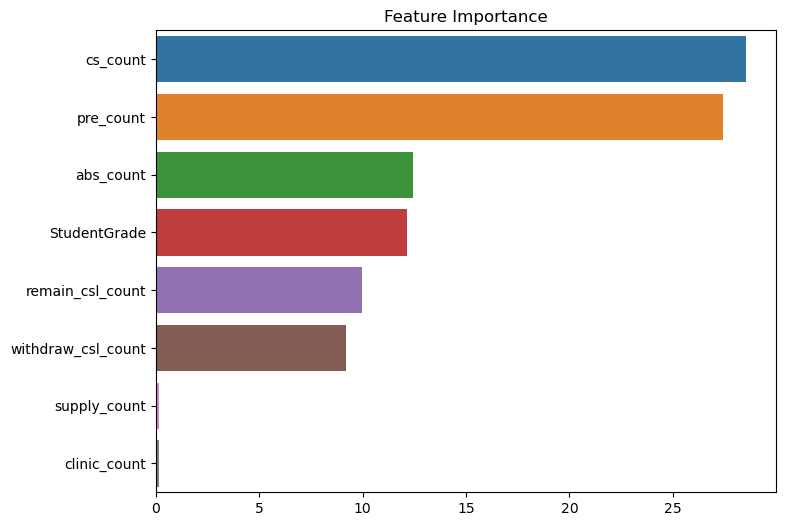

In [59]:
# 피처 중요도
ft_importance_values = cat_best.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()